The aim of this notebook is to use the Levenberg–Marquardt algorithm to fit a logistic function onto cumulative global COVID-19 deaths.

Author: Aditya Ranjan

<a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/">Creative Commons Attribution-NonCommercial 4.0 International License</a>.

In [32]:
#Import essential libraries
import math
import numpy as np
import pandas as pd
from random import randint
import matplotlib.pyplot as plt
from scipy.optimize import least_squares

In [33]:
#Load data into a pandas data frame
#Source - https://www.google.com/search?q=john+hopkins+github
data = pd.read_csv("globalDeaths.csv")
data = data.drop(["Province/State", "Country/Region", "Lat", "Long"], axis = 1)
data.head()

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,...,5/8/20,5/9/20,5/10/20,5/11/20,5/12/20,5/13/20,5/14/20,5/15/20,5/16/20,5/17/20,5/18/20,5/19/20,5/20/20,5/21/20,5/22/20,5/23/20,5/24/20,5/25/20,5/26/20,5/27/20,5/28/20,5/29/20,5/30/20,5/31/20,6/1/20,6/2/20,6/3/20,6/4/20,6/5/20,6/6/20,6/7/20,6/8/20,6/9/20,6/10/20,6/11/20,6/12/20,6/13/20,6/14/20,6/15/20,6/16/20
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,109,115,120,122,127,132,136,153,168,169,173,178,187,193,205,216,218,219,220,227,235,246,249,257,265,270,294,300,309,327,357,369,384,405,426,446,451,471,478,491
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,32,32,33,33,33,33,33,33,33,33,33,33,33,34,34,34,34,34,35,36,36,36,36,37
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,488,494,502,507,515,522,529,536,542,548,555,561,568,575,582,592,600,609,617,623,630,638,646,653,661,667,673,681,690,698,707,715,724,732,741,751,760,767,777,788
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,47,48,48,48,48,49,49,49,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,52
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,2,2,2,2,2,2,2,2,2,2,3,3,3,3,3,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,5,5,6,6,6,6


In [34]:
#Min-Max normalize data (prevents overflow errors and easier to work with in general)
x = np.array([i for i in range(len(y))])
x = (x - np.min(x)) / (np.max(x) - np.min(x))

y = np.sum(data, axis = 0)
y = (y - np.min(y)) / (np.max(y) - np.min(y))

In [35]:
#Important functions

#Logistic function
def model(p, x):
  return p[0] / (1 + (p[1] * (math.e ** (p[2] * x))))


#Returns residual: predicted - actual
def fun(p, x, y):
  return model(p, x) - y


#Returns the jacobian matrix: derivatives of residuals with respect to each parameter
def jac(p, x, y):
  J = np.empty((x.size, p.size))
  J[:, 0] = 1 / (1 + (p[1] * (math.e ** (p[2] * x))))
  J[:, 1] = (-p[0] * (math.e ** (p[2] * x))) / ((1 + ((math.e ** (p[2] * x)) * p[1])) ** 2)
  J[:, 2] = (-p[0] * p[1] * x * (math.e ** (p[2] * x))) / ((1 + ((math.e ** (p[2] * x)) * p[1])) ** 2)
  return J

In [42]:
#Scipy least squares method

#Initialize parameters
p0 = np.array([1, randint(100, 200), randint(-10, -5)])

#Use scipy least squares to minimize the cost
bestP = least_squares(fun, p0, jac = jac, args = (x, y), verbose = 1)

`ftol` termination condition is satisfied.
Function evaluations 18, initial cost 3.9492e+00, final cost 5.1359e-02, first-order optimality 6.97e-07.


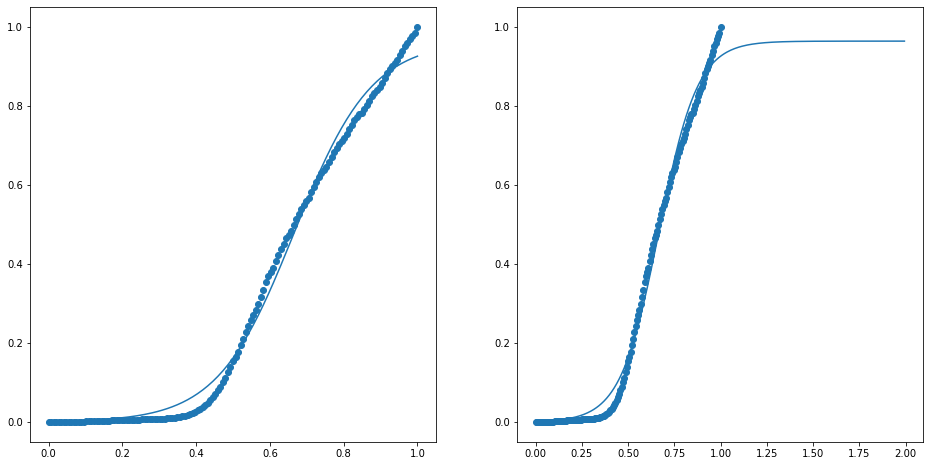

[  0.96348039 595.70362126  -9.57893875]


In [43]:
#Plot the predicted values against the actual values
plt.rcParams["figure.figsize"] = (16, 8)

plt.subplot(121)
plt.scatter(x, y)
plt.plot(x, model(bestP.x, x))

plt.subplot(122)
tempX = np.arange(0, 2, x[1])
plt.scatter(x, y)
plt.plot(tempX, model(bestP.x, tempX))

plt.show()

#Parameter values after using scipy least squares
print(bestP.x)

In [44]:
#Using the Levenberg–Marquardt algorithm
#Source - https://mads.lanl.gov/presentations/Leif_LM_presentation_m.pdf

#Initialize parameters
p0 = np.array([1, randint(100, 200), randint(-10, -5)])
d, dUp, dDown = 0.1, 2, 2

temp = []

#Levenberg–Marquardt algorithm
for i in range(50):
  res, derivs = fun(p0, x, y), jac(p0, x, y)
  temp.append(np.sum(res))

  g = np.dot(derivs.T, derivs) + d
  costGrad = np.dot(derivs.T, res)
  cost = np.sum(0.5 * (res ** 2))

  pNew = p0 - np.dot(np.linalg.inv(g), costGrad)
  resNew = fun(pNew, x, y)
  costNew = np.sum(0.5 * (resNew ** 2))

  if costNew < cost:
    p0 = pNew
    d /= dDown
  else:
    d *= dUp

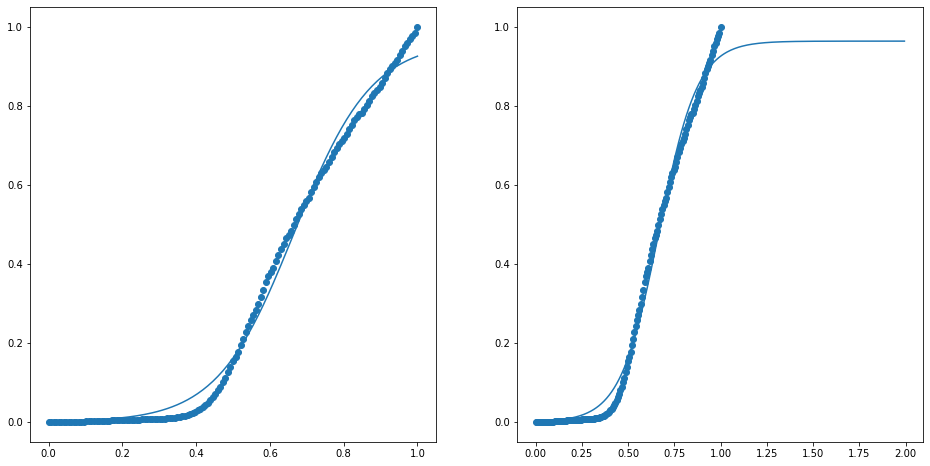

[  0.96348077 595.70301955  -9.57893476]


In [45]:
#Plot the predicted values against the actual values
plt.subplot(121)
plt.scatter(x, y)
plt.plot(x, model(p0, x))

plt.subplot(122)
plt.scatter(x, y)
plt.plot(tempX, model(p0, tempX))

plt.show()

#Parameter values after executing the Levenberg–Marquardt algorithm
print(p0)

As can be seen from the parameters and graphs above, both scipy least squares and my implementation of the Levenberg–Marquardt algorithm are not predicting the global cumulative deaths well. They both performed much better on the global cumulative cases. The reality is that cases and deaths rely on several factors and mathematical modeling is not accurate in predicting the future of the COVID-19 pandemic.